In [1]:
import numpy as np
import pandas as pd

In [2]:
train_df = pd.read_csv('../train.csv',index_col="tripid")

In [3]:
train_df

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
tripid,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct
...,...,...,...,...,...,...,...,...,...,...,...,...,...
213803193,10.5,838.0,93.0,5.4219,451.0,1/31/2020 22:07,1/31/2020 22:21,7.29073,80.6367,7.28891,80.6557,198.26,correct
213812756,10.5,2151.0,428.0,0.0000,39.0,1/31/2020 23:07,1/31/2020 23:43,6.90569,79.8516,6.95089,79.9389,581.23,correct
213813930,10.5,263.0,9.0,0.0000,110.0,1/31/2020 23:21,1/31/2020 23:25,7.09210,79.9000,7.10135,79.9017,76.20,correct


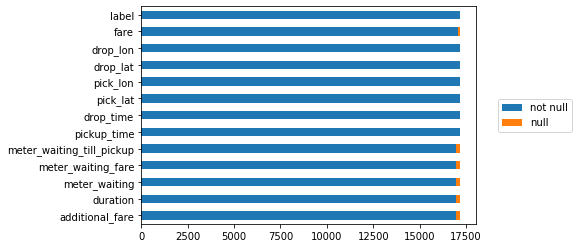

In [4]:
ax = pd.DataFrame({'not null': train_df.count(),
                   'null': train_df.isnull().sum()}).plot.barh(stacked=True)

ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5)
)

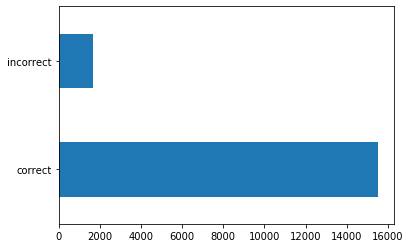

In [5]:
train_df['label'].value_counts().plot.barh()

In [6]:
from sklearn.preprocessing import label_binarize, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score

RANDOM_SEED = 5    # Set a random seed for reproducibility!

In [7]:
def preprocessTrainData(train_df):
    #labels
    labels_df = train_df.loc[:, train_df.columns == 'label']
    
    labels_df = pd.DataFrame(label_binarize(labels_df, classes=['incorrrect', 'correct']))
    
    labels_df.columns = labels_df.columns
    labels_df.index = labels_df.index
    
    # features
    features_df = train_df.drop(columns=['label'])
    
    numeric_cols = features_df.columns[features_df.dtypes != "object"].values
    
    non_numeric_cols = features_df.columns[features_df.dtypes == "object"].values
    
    #numeric
    scaler = RobustScaler()
    features_df[numeric_cols] = scaler.fit_transform(features_df[numeric_cols])

    imputer = SimpleImputer(strategy='mean')
    features_df[numeric_cols] = imputer.fit_transform(features_df[numeric_cols])

    #date time
    features_df['pickup_time'] = pd.to_datetime(features_df['pickup_time'])
    features_df['drop_time'] = pd.to_datetime(features_df['drop_time'])
    
    features_df['pickup_day_of_week'] = features_df['pickup_time'].dt.day_name()
    features_df['drop_day_of_week'] = features_df['drop_time'].dt.day_name()
    
    features_df['pickup_hour'] = features_df['pickup_time'].dt.hour
    features_df['drop_hour'] = features_df['drop_time'].dt.hour
    
    features_df = pd.get_dummies(features_df, columns = ['pickup_day_of_week', 'drop_day_of_week'])
    
    features_df = features_df.drop(columns=['pickup_time','drop_time'])
    
    return features_df, labels_df

In [8]:
features_df, labels_df = preprocessTrainData(train_df)

In [9]:
features_df

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,...,pickup_day_of_week_Thursday,pickup_day_of_week_Tuesday,pickup_day_of_week_Wednesday,drop_day_of_week_Friday,drop_day_of_week_Monday,drop_day_of_week_Saturday,drop_day_of_week_Sunday,drop_day_of_week_Thursday,drop_day_of_week_Tuesday,drop_day_of_week_Wednesday
tripid,,,,,,,,,,,,,,,,,,,,,
189123628,0.000000,-0.139841,-0.210692,-0.008130,-0.076271,-0.289836,0.008121,-0.070827,-0.230791,0.245445,...,0,0,0,1,0,0,0,0,0,0
189125358,0.000000,-0.174104,-0.238994,-0.008130,0.516949,-0.158529,-0.002320,-0.013383,-0.075451,-0.055323,...,0,0,0,1,0,0,0,0,0,0
189125719,0.000000,0.061753,-0.135220,-0.008130,-0.101695,-0.032110,-0.388631,0.113069,0.171983,0.375431,...,0,0,0,1,0,0,0,0,0,0
189127273,0.000000,-0.327888,0.465409,1.084048,-0.042373,0.065148,-0.105568,0.062345,-0.022191,-0.534883,...,0,0,0,1,0,0,0,0,0,0
189128020,3.219651,0.552477,1.591428,2.227131,0.334465,-0.223031,-0.430394,-0.393127,0.331761,0.610957,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213803193,0.000000,-0.136653,-0.094340,0.369919,3.203390,2.116109,8.562645,2.052927,8.395007,-0.053621,...,0,0,0,1,0,0,0,0,0,0
213812756,0.000000,0.909562,0.959119,-0.008130,-0.288136,-0.047281,-0.545244,0.191276,0.441609,1.535796,...,0,0,0,1,0,0,0,0,0,0
213813930,0.000000,-0.594821,-0.358491,-0.008130,0.313559,1.000084,0.016241,1.019937,0.028849,-0.560199,...,0,0,0,1,0,0,0,0,0,0


In [10]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    labels_df,
    test_size=0.2,
    shuffle=True,
    stratify=labels_df,
    random_state=RANDOM_SEED
)

X_train.dtypes

additional_fare                 float64
duration                        float64
meter_waiting                   float64
meter_waiting_fare              float64
meter_waiting_till_pickup       float64
pick_lat                        float64
pick_lon                        float64
drop_lat                        float64
drop_lon                        float64
fare                            float64
pickup_hour                       int64
drop_hour                         int64
pickup_day_of_week_Friday         uint8
pickup_day_of_week_Monday         uint8
pickup_day_of_week_Saturday       uint8
pickup_day_of_week_Sunday         uint8
pickup_day_of_week_Thursday       uint8
pickup_day_of_week_Tuesday        uint8
pickup_day_of_week_Wednesday      uint8
drop_day_of_week_Friday           uint8
drop_day_of_week_Monday           uint8
drop_day_of_week_Saturday         uint8
drop_day_of_week_Sunday           uint8
drop_day_of_week_Thursday         uint8
drop_day_of_week_Tuesday          uint8


In [11]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [26]:
y_pred = rf.predict(X_eval)
print('F1 score: {:.6f}'.format(f1_score(y_eval, y_pred)))
print('F1 score: {:.6f}'.format(f1_score(y_eval, y_pred, average='macro')))

F1 score: 0.966176
F1 score: 0.760866


In [13]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features_df, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: duration             Importance: 0.22
Variable: fare                 Importance: 0.16
Variable: meter_waiting        Importance: 0.09
Variable: meter_waiting_till_pickup Importance: 0.07
Variable: meter_waiting_fare   Importance: 0.06
Variable: pick_lat             Importance: 0.06
Variable: pick_lon             Importance: 0.06
Variable: drop_lat             Importance: 0.06
Variable: drop_lon             Importance: 0.06
Variable: additional_fare      Importance: 0.04
Variable: pickup_hour          Importance: 0.04
Variable: drop_hour            Importance: 0.03
Variable: pickup_day_of_week_Monday Importance: 0.01
Variable: drop_day_of_week_Monday Importance: 0.01
Variable: pickup_day_of_week_Friday Importance: 0.0
Variable: pickup_day_of_week_Saturday Importance: 0.0
Variable: pickup_day_of_week_Sunday Importance: 0.0
Variable: pickup_day_of_week_Thursday Importance: 0.0
Variable: pickup_day_of_week_Tuesday Importance: 0.0
Variable: pickup_day_of_week_Wednesday Importance:

In [35]:
from sklearn.model_selection import GridSearchCV

param_grid = [
{'n_estimators': [10, 25], 'max_features': [5, 10], 
 'max_depth': [10, 50, None], 'bootstrap': [True, False]}
]

grid_search_forest = GridSearchCV(rf, param_grid, cv=10, scoring='f1_macro', n_jobs = -1)
grid_search_forest.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [36]:
#find the best model of grid search
grid_search_forest.best_params_

{'bootstrap': False, 'max_depth': None, 'max_features': 10, 'n_estimators': 25}

In [38]:
grid_best= grid_search_forest.best_estimator_.predict(X_eval)

In [39]:
print('F1 score: {:.6f}'.format(f1_score(y_eval, grid_best)))
print('F1 score: {:.6f}'.format(f1_score(y_eval, grid_best, average='macro')))

F1 score: 0.969056
F1 score: 0.802372


In [41]:
param_grid_2 = [
{'n_estimators': [50, 100, 200, 300], 'max_features': ['sqrt'], 
 'max_depth': [30, 50, 100], 'bootstrap': [False], 'min_samples_split': [3, 5]}
]

grid_search_forest_2 = GridSearchCV(rf, param_grid_2, cv=10, scoring='f1_macro', n_jobs = -1)
grid_search_forest_2.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [43]:
#find the best model of grid search
grid_search_forest_2.best_params_

{'bootstrap': False,
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_split': 3,
 'n_estimators': 50}

In [44]:
grid_best_2= grid_search_forest_2.best_estimator_.predict(X_eval)

In [45]:
print('F1 score: {:.6f}'.format(f1_score(y_eval, grid_best_2)))
print('F1 score: {:.6f}'.format(f1_score(y_eval, grid_best_2, average='macro')))

F1 score: 0.966971
F1 score: 0.779205


In [51]:
rf2 = RandomForestClassifier(bootstrap = False,
 max_depth= 50,
 max_features = 10,
 min_samples_split = 3,
 n_estimators = 200)

In [52]:
rf2.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [53]:
y_pred_2 = rf2.predict(X_eval)
print('F1 score: {:.6f}'.format(f1_score(y_eval, y_pred_2)))
print('F1 score: {:.6f}'.format(f1_score(y_eval, y_pred_2, average='macro')))

F1 score: 0.970472
F1 score: 0.811767


In [21]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'max_features': 'sqrt',
 'max_depth': 45}

In [22]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph

ModuleNotFoundError: No module named 'pydot'